# Unsupervised Learning
***Eric Gu <br>
November 20, 2018***

- - -

This notebook will explore two cluster algorithms:
* *K*-means clustering
* GMMs via Expectation Maximization

... And a dimensionality reduction algorithm:
* Principal component analysis (PCA)

We will be using the same two datasets from the previous assignments. 

*Written in Jupyter Notebook using Python's scikit-learn library and [documentation](http://scikit-learn.org/stable/user_guide.html), and with additional reference to [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/). Data sourced from [Kaggle.com](https://www.kaggle.com/datasets).* 

In [66]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from time import time

%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn import datasets

np.random.seed(42)

## Dataset Recap

### Avocado Prices
Our first dataset is on Hass avocado prices from 2015–2018, downloaded from the Hass Avocado Board website in May 2018 and [compiled on Kaggle.com](https://www.kaggle.com/neuromusic/avocado-prices). We'll try to predict the average price of avocados by clustering on sales numbers, date & time, and location.

In [67]:
avocado_data = pd.read_csv("./Datasets/avocado-prices.csv", sep=',', header='infer', index_col=0)
avocado_data.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,month,day,year,region
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,12,27,2015,Albany
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,12,20,2015,Albany
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,12,13,2015,Albany
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,12,6,2015,Albany
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,11,29,2015,Albany


The dataset contains 18249 rows of weekly retail scan data for national retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. 

The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU's) correspond to the following:

* Small/Medium Hass Avocado (~3-5oz avocado) | #4046
* Large Hass Avocado (~8-10oz avocado) | #4225
* Extra Large Hass Avocado (~10-15oz avocado) | #4770

This dataset is relatively simple: it has few real features, some of which are likely already correlated. Furthermore, we will encode the categorical variables and discretize the average prices to turn it into a multiclass classification problem, increasing the dimensionality of the problem and making the number of correlated columns even higher. Because it comes from real-world sales, the dataset is likely messy and will provide an interesting comparison between the two clustering algorithms' sensitivity to noise (before and after dimensionality reduction). Perhaps most importantly, this dataset contains only a posteriori information on average prices of avocado sales in relation to the times and locations they were sold at. Without feature engineering additional data like weather, transportation costs (e.g. oil prices), and cost of living, we can only rely on PCA to uncover those potentially underlying causal relationships that correlate with time and location. 

#### Preprocessing
The data is missing no values, and is well-balanced across type, region, and datetime. I've broken the original 'Date' feature into 'month', 'day,' and 'year' columns in the CSV before importing. For the sake of brevity, we will skip rudimentary data visualization and inspection in this notebook. 

Before doing anything, let's first split our data into training and testing sets. Just to be safe, we will do everything we do to the training set to the testing set, in parallel.

In [68]:
avocado_train, avocado_test = train_test_split(avocado_data, test_size=0.2)

##### Feature Engineering and Standardization
However, we do need to change our raw feature vectors into a representation more suitable for our downstream estimators. This includes encoding categorical features into numerical values and standardizing the data. We won't belabor the reader by explaining every step of the code as before. 

In [116]:
# Cols "Total Volume" to "XLarge Bags"
unscaled_cols = avocado_train.columns[1:9]

avocado_train_scaled = avocado_train.copy()
avocado_test_scaled = avocado_test.copy()

scaler = StandardScaler()
avocado_train_scaled[unscaled_cols] = scaler.fit_transform(avocado_train_scaled[unscaled_cols])
avocado_test_scaled[unscaled_cols] = scaler.fit_transform(avocado_test_scaled[unscaled_cols])

In [117]:
# Use Pandas get_dummies() to one-hot encode categorical variables
avocado_train_encoded = pd.get_dummies(avocado_train_scaled, columns=["region", "type", "year"], prefix=["region", "type", "year"])
avocado_test_encoded = pd.get_dummies(avocado_test_scaled, columns=["region", "type", "year"], prefix=["region", "type", "year"])

In [118]:
# Normalize day and month to sin and cos, assuming months are uniformly 30 days long
avocado_train_encoded['day_sin'] = np.sin(avocado_train_encoded.day*(2.*np.pi/30))
avocado_train_encoded['day_cos'] = np.cos(avocado_train_encoded.day*(2.*np.pi/30))
avocado_train_encoded['month_sin'] = np.sin((avocado_train_encoded.month-1)*(2.*np.pi/12))
avocado_train_encoded['month_cos'] = np.cos((avocado_train_encoded.month-1)*(2.*np.pi/12))
del avocado_train_encoded['month']
del avocado_train_encoded['day']

avocado_test_encoded['day_sin'] = np.sin(avocado_test_encoded.day*(2.*np.pi/30))
avocado_test_encoded['day_cos'] = np.cos(avocado_test_encoded.day*(2.*np.pi/30))
avocado_test_encoded['month_sin'] = np.sin((avocado_test_encoded.month-1)*(2.*np.pi/12))
avocado_test_encoded['month_cos'] = np.cos((avocado_test_encoded.month-1)*(2.*np.pi/12))
del avocado_test_encoded['month']
del avocado_test_encoded['day']

To convert this to a classification problem, we'll discretize our output (average price of avocados) into 5 classes, corresponding to quantile-based price ranges (from "Very Cheap" to "Very Pricey"). 

In [119]:
# Identify bin cutoffs that that divide AveragePrice into 5 quantiles
train_ser, train_bins = pd.qcut(avocado_train_encoded["AveragePrice"], 5, retbins=True, labels=False)
test_ser, test_bins = pd.qcut(avocado_test_encoded["AveragePrice"], 5, retbins=True, labels=False)

# Replace AveragePrice with LabeledPrice, a categorical variable
avocado_price_range_labels = ["Very Cheap", "Cheap", "Average", "Pricey", "Very Pricey"]
trainLabeledPrice = pd.cut(avocado_train_encoded["AveragePrice"], bins=train_bins, labels=avocado_price_range_labels, include_lowest=True)
testLabeledPrice = pd.cut(avocado_test_encoded["AveragePrice"], bins=test_bins, labels=avocado_price_range_labels, include_lowest=True)


avocado_train_processed = avocado_train_encoded.copy()
avocado_test_processed = avocado_test_encoded.copy()

avocado_train_processed.insert(loc=0, column="Price", value=trainLabeledPrice)
avocado_test_processed.insert(loc=0, column="Price", value=testLabeledPrice)
del avocado_train_processed['AveragePrice']
del avocado_test_processed['AveragePrice']

avocado_Y_train = avocado_train_processed.iloc[:, :1]
avocado_X_train = avocado_train_processed.iloc[:, 1:]
avocado_Y_test = avocado_test_processed.iloc[:, :1]
avocado_X_test = avocado_test_processed.iloc[:, 1:]

avocado_X = pd.concat([avocado_X_train, avocado_X_test])
avocado_Y = pd.concat([avocado_Y_train, avocado_Y_test])

### Breast Cancer in Wisconsin
For our second classification problem, we'll explore a smaller, less balanced dataset on breast cancer diagnostics published in a paper from the University of Wisconsin. It was donated to the UCI Machine Learning repository in 1995 and is available on [Kaggle.com](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/).

In [73]:
cancer_data = pd.read_csv("./Datasets/breast-cancer-wisconsin-data.csv", sep=',', header='infer', index_col=0)
cancer_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus: 

a) radius (mean of distances from center to points on the perimeter) <br>
b) texture (standard deviation of gray-scale values) <br>
c) perimeter <br>
d) area <br>
e) smoothness (local variation in radius lengths) <br>
f) compactness (perimeter^2 / area - 1.0) <br>
g) concavity (severity of concave portions of the contour) <br>
h) concave points (number of concave portions of the contour) <br>
i) symmetry <br>
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.

We expect that many of the real and engineered features will be correlated, and not all need to be included as inputs into the clustering algorithms. Dimensionality reduction will certainly help reduce a lot of noise and improve the test performance of those algorithms. 

#### Preprocessing
Splitting the data into training and testing sets before proceeding:

In [74]:
cancer_train, cancer_test = train_test_split(cancer_data, test_size=0.2)

##### Standardization

Just like in the Avocado Prices problem, we will standardize the dataset(s) to help our models fit better during training. Not previously mentioned, but it's important that we standardize training and testing data separately so as not to let the training data glean information like mean & variance from the testing set. 

In [75]:
scaler = StandardScaler()
unscaled_cols = cancer_train.columns[1:32]

cancer_train_scaled = cancer_train.copy()
cancer_test_scaled = cancer_test.copy()
cancer_train_scaled[unscaled_cols] = scaler.fit_transform(cancer_train_scaled[unscaled_cols])
cancer_test_scaled[unscaled_cols] = scaler.fit_transform(cancer_test_scaled[unscaled_cols])

Encode the output labels from 'B[enign]' and 'M[alignant]' to 0 and 1. 

In [76]:
# Use Pandas replace() to one-hot encode categorical output
cleanup_output = {"B": 0, "M": 1}
cancer_train_scaled.replace(cleanup_output, inplace=True)
cancer_test_scaled.replace(cleanup_output, inplace=True)

# Split data into features and outputs
cancer_Y_train = cancer_train_scaled.iloc[:, :1]
cancer_X_train = cancer_train_scaled.iloc[:, 1:]
cancer_Y_test = cancer_test_scaled.iloc[:, :1]
cancer_X_test = cancer_test_scaled.iloc[:, 1:]

cancer_X = pd.concat([cancer_X_train, cancer_X_test])
cancer_Y = pd.concat([cancer_Y_train, cancer_Y_test])

- - -

## Clustering Without PCA

### *K*-means Clustering
We will be using the KMeans and PCA algorithms from scikit-learn library, and comparing the results from running them on each dataset using several clustering performance evaluators. This implementation uses flat geometry (distances between points) for its distance metric. An important observation for K-means is that the cluster models *must be circular* and are nonprobabilistic, which means that it cannot account for oblong or overlapping clusters very well. Both our datasets are noisy (the avocado dataset more so than the cancer dataset), and they likely overlap and do not fit into neat circular clusters in hyperspace. Some of these issues can be alleviated with PCA, but I predict we may have more success with GMMs. 

In [77]:
def bench_k_means(estimator, name, data, labels, sample_size):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

def find_k(data_x, data_y, x_range):
    # Instantiate the clustering model and visualizer
    kMeansModel = KMeans()
    visualizer = KElbowVisualizer(kMeansModel, k=x_range, metric='calinski_harabaz')

    visualizer.fit(data_x, data_y)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data
    
def k_means(data_x, data_y, k=5, n_init=10):
    n_samples, n_features = data_x.shape
    n_digits = len(np.unique(data_y))
    labels = data_y

    sample_size = 300

    print("n_digits: %d, \t n_samples %d, \t n_features %d"
          % (n_digits, n_samples, n_features))

    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

    bench_k_means(KMeans(init='k-means++', n_clusters=k, n_init=n_init),
                  name="k-means++", data=data_x, labels=labels, sample_size=sample_size)

    bench_k_means(KMeans(init='random', n_clusters=k, n_init=n_init),
                  name="random", data=data_x, labels=labels, sample_size=sample_size)
    print(82 * '_')

First, we need to find an appropriate *K* (the number of clusters) to run the algorithm on. We'll graph the algorithm's average performance for k = (2,15) measured by the Calinski Harabaz score, defined as the ratio between within-cluster dispersion and between-cluster dispersion.

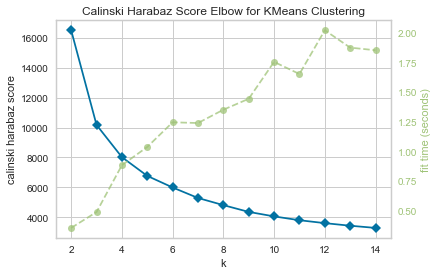

In [78]:
find_k(avocado_X, avocado_Y, (2,15))

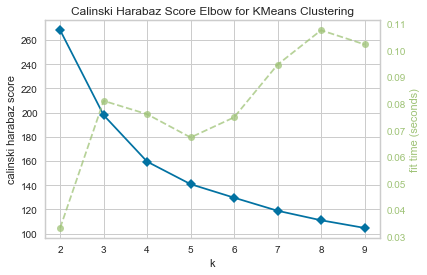

In [79]:
find_k(cancer_X, cancer_Y, (2,10))

Seeing as there is no clear point of inflection in either of the line charts (they start at peak k=2), we will rely on our domain knowledge of the true number of classes: the avocado dataset has 5 clusters by construction (corresponding to 5 price ranges), and the cancer dataset has 2 clusters (corresponding to Benign or Malignant). 

Now we can run *K*-means. We want to focus more on adjusted Rand Index (ARI) for the Avocado model because its ground truth clustering has large, balanced classes by construction; we'll focus on Adjusted Mutual Information (AMI) for the Cancer model because its ground truth clustering is unbalanced and has fewer Malignant than Benign cases. 

In [15]:
k_means(avocado_X, avocado_Y.values.ravel(), n_init=50)

n_digits: 5, 	 n_samples 18249, 	 n_features 72
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	4.90s	87749	0.149	0.255	0.188	0.150	0.148	0.119
random   	5.55s	90410	0.157	0.198	0.175	0.134	0.157	0.092
__________________________________________________________________________________


In [16]:
k_means(cancer_X, cancer_Y.values.ravel(), k=2)

n_digits: 2, 	 n_samples 569, 	 n_features 30
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.05s	11590	0.544	0.563	0.553	0.671	0.543	0.353
random   	0.04s	11590	0.537	0.555	0.546	0.665	0.537	0.353
__________________________________________________________________________________


The results are lackluster for the avocado data. While it's hard to visualize what these clusters might look like in hyperspace, the silhouette score is close to 0, indicating that many points are very close to the decision boundaries and the clusters heavily overlap. The ARI is 0.150, which indicates very low agreement, resembling something closer to random label assignments. This is not surprising, seeing as the dataset has had no dimensionality reduction and *K*-means is sensitive to outliers and noise. Additionally, we ran the algorithm for 50 initializations using k-means++ seeding to ameliorate the algorithm's proneness to local minima, but we saw negligible gains on our evaluation measures over random seeding. The state space is still very large and may hide more optimal clusterings. 

*K*-means worked better for the cancer data, which was much smaller and had fewer features. The silhouette score of 0.353 suggests that the clusters have less overlap. The AMI was 0.543, which indicates clusterings quite similar to the ground truth, verging on significant agreement. 

### GMMs via Expectation Maximization
As mentioned earlier, GMMs are more flexible because they allow for probabilistic cluster assignments. We'll be using GaussianMixture from scikit-learn, which uses Mahalanobis distance. Under the hood, it uses an expectation-maximization approach to a process very similar to K-means. For the sake of comparison, we will use the same number of components and initializations for our GMMs as the number of clusters we used for *K*-means, but we will allow for the model to use full covariance (which corresponds to the true generative model) and seed instances using both K-means and random assignment.

Text(0.5,1,'AIC & BIC of GMM, Avocado Dataset')

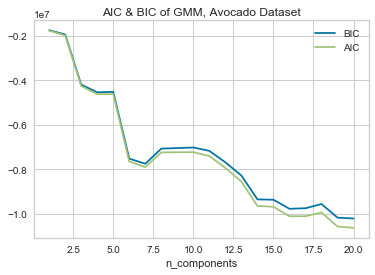

In [132]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(avocado_X)
          for n in n_components]

plt.plot(n_components, [m.bic(avocado_X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(avocado_X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('AIC & BIC of GMM, Avocado Dataset')

Text(0.5,1,'AIC & BIC of GMM, Cancer Dataset')

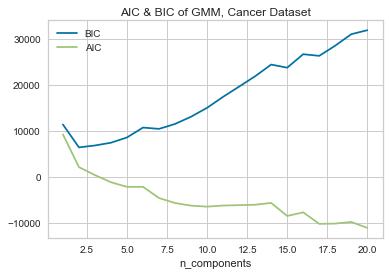

In [130]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cancer_X)
          for n in n_components]

plt.plot(n_components, [m.bic(cancer_X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cancer_X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('AIC & BIC of GMM, Cancer Dataset')

In [80]:
def bench_GMMs(estimator, name, data, labels, sample_size):
    t0 = time()
    y_pred = estimator.fit(data).predict(data)
    print('%-9s\t%.2is\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0),
             metrics.homogeneity_score(labels, y_pred),
             metrics.completeness_score(labels, y_pred),
             metrics.v_measure_score(labels, y_pred),
             metrics.adjusted_rand_score(labels, y_pred),
             metrics.adjusted_mutual_info_score(labels,  y_pred),
             metrics.silhouette_score(data, y_pred,
                                      metric='euclidean',
                                      sample_size=sample_size)))

def GMMs(data_x, data_y, k=5, n_init=10):
    n_samples, n_features = data_x.shape
    n_digits = len(np.unique(data_y))
    labels = data_y

    sample_size = 300

    print("n_digits: %d, \t n_samples %d, \t n_features %d"
          % (n_digits, n_samples, n_features))

    print(82 * '_')
    print('init\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    
    bench_GMMs(GaussianMixture(n_components=k, n_init=n_init, init_params="kmeans", covariance_type="full"), 
              name="kmeans", data=data_x, labels=labels, sample_size=sample_size)
    
    bench_GMMs(GaussianMixture(n_components=k, n_init=n_init, init_params="random", covariance_type="full"), 
              name="random", data=data_x, labels=labels, sample_size=sample_size)
    print(82 * '_')

In [54]:
GMMs(avocado_X, avocado_Y.values.ravel(), n_init=50)

n_digits: 5, 	 n_samples 18249, 	 n_features 72
__________________________________________________________________________________
init		time	homo	compl	v-meas	ARI	AMI	silhouette
kmeans   	147s	0.029	0.035	0.032	0.013	0.029	0.009
random   	121s	0.007	0.007	0.007	0.005	0.007	-0.084
__________________________________________________________________________________


In [55]:
GMMs(cancer_X, cancer_Y.values.ravel(), k=2)

n_digits: 2, 	 n_samples 569, 	 n_features 30
__________________________________________________________________________________
init		time	homo	compl	v-meas	ARI	AMI	silhouette
kmeans   	00s	0.612	0.606	0.609	0.725	0.605	0.313
random   	00s	0.562	0.549	0.556	0.667	0.549	0.282
__________________________________________________________________________________


The GMMs performed with mixed results. Surprisingly, it took about 30 times longer to run than *K*-means in wall clock time and resulted in an adjusted Rand Index of 0.013 for the Avocado dataset, roughly equivalent to completely random (uniform) label assignments. The silhouette score is next to 0, meaning the model's clusters largely overlap. We can conclude that this model failed. 

The Cancer dataset fared better on the other hand, with an AMI of 0.605. In hindsight, the long running time for the Avocado dataset was not unexpected, but the low performance reflects the difficulty in initializing Gaussian components with very high dimensional data and many parameters. The Cancer model is small, and must have benefited from the additional flexibility of nonspherical cluster geometry and "soft" assignment, since the silhouette suggests that the clusters have about the same amount of overlap as the *K*-means model. 

## PCA
Now, let's perform some dimensionality reduction on our datasets. Graphing cumulative explained variance against the first *n* components:

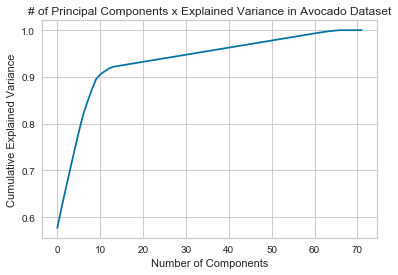

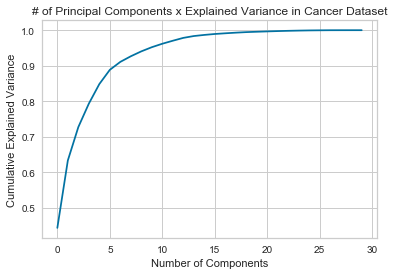

In [81]:
def chooseNumComponents(data, title):
    pca = PCA().fit(data)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance');
    plt.title(title)
    plt.show()

chooseNumComponents(avocado_X, "# of Principal Components x Explained Variance in Avocado Dataset")
chooseNumComponents(cancer_X, "# of Principal Components x Explained Variance in Cancer Dataset")

The graphs are quite striking. The Avocado dataset hits rapidly diminishing returns after around 10 or 11 components, while the Cancer dataset has most of its gains in the first 5 components.

In [32]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

pcaAvocado = PCA(n_components=11)
pcaAvocado.fit(avocado_X)
avocado_X_pca = pcaAvocado.transform(avocado_X)
print("PCA Transformed Avocado Data\n", avocado_X_pca)

pcaCancer = PCA(n_components=5)
pcaCancer.fit(cancer_X)
cancer_X_pca = pcaCancer.transform(cancer_X)
print("PCA Transformed Cancer Data\n", cancer_X_pca)

PCA Transformed Avocado Data
 [[-0.698 -0.203  0.275 ...,  0.438 -0.63  -0.007]
 [-0.065 -0.914 -0.241 ..., -0.824  0.033  0.148]
 [-0.699  0.149 -0.421 ..., -0.761 -0.037 -0.092]
 ..., 
 [ 0.06  -0.926 -0.265 ..., -0.782 -0.019 -0.314]
 [-0.647  0.453  1.208 ...,  0.361 -0.631 -0.002]
 [-0.603  0.722  1.164 ...,  0.369 -0.633 -0.01 ]]
PCA Transformed Cancer Data
 [[ 4.737 -1.576 -1.222 -0.076 -0.158]
 [ 2.231 -2.739 -1.622  0.122 -0.003]
 [ 2.075  1.043  1.771  0.231 -0.979]
 ..., 
 [-2.472  2.608  2.464 -1.565 -3.134]
 [-0.977  1.742 -1.321  0.301  0.102]
 [ 7.358  0.34  -2.94   0.236 -2.261]]


There are now 11 and 5 columns in the reduced Avocado and Cancer datasets, respectively. The transformed datasets are otherwise not very meaningful to human inspection, and are difficult to graph in 2D.

## Clustering With PCA

We now run all the previous clustering algorithms on the newly transformed columns for each of our problems. 

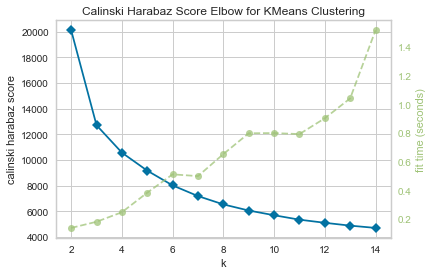

In [34]:
find_k(avocado_X_pca, avocado_Y, (2,15))

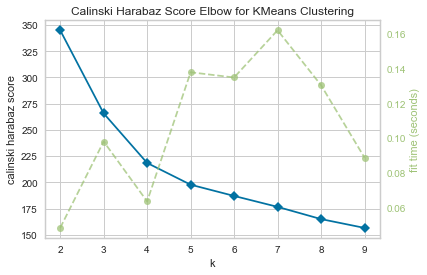

In [35]:
find_k(cancer_X_pca, cancer_Y, (2,10))

Again, the elbow method does not give us a clear inflection point, so we'll keep the number of clusters the same as before.

In [39]:
k_means(avocado_X_pca, avocado_Y.values.ravel(), n_init=50)

n_digits: 5, 	 n_samples 18249, 	 n_features 11
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	2.11s	66877	0.149	0.256	0.188	0.150	0.148	0.153
random   	3.14s	69538	0.157	0.199	0.175	0.134	0.157	0.137
__________________________________________________________________________________


In [40]:
k_means(cancer_X_pca, cancer_Y.values.ravel(), k=2)

n_digits: 2, 	 n_samples 569, 	 n_features 5
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.05s	9003	0.537	0.555	0.546	0.665	0.537	0.362
random   	0.03s	9003	0.537	0.555	0.546	0.665	0.537	0.401
__________________________________________________________________________________


In [56]:
GMMs(avocado_X_pca, avocado_Y.values.ravel(), n_init=50)

n_digits: 5, 	 n_samples 18249, 	 n_features 11
__________________________________________________________________________________
init		time	homo	compl	v-meas	ARI	AMI	silhouette
kmeans   	31s	0.139	0.149	0.144	0.120	0.139	-0.012
random   	47s	0.152	0.172	0.162	0.120	0.152	0.071
__________________________________________________________________________________


In [57]:
GMMs(cancer_X_pca, cancer_Y.values.ravel(), k=2)

n_digits: 2, 	 n_samples 569, 	 n_features 5
__________________________________________________________________________________
init		time	homo	compl	v-meas	ARI	AMI	silhouette
kmeans   	00s	0.408	0.390	0.399	0.466	0.389	0.296
random   	00s	0.402	0.383	0.392	0.457	0.383	0.284
__________________________________________________________________________________


The results are not too exciting. Avocado _K_-means model has ARI of 0.150 (exact same as before) and the Cancer *K*-means model has AMI of 0.537 (slightly lower than before). Wall clock run times for the Avocado model halved and theoretically the clustering models for both should be more generalizable to new out-of-sample data, so it's impressive that in-sample performance stayed the same. 

If anything, the performance for GMMs deteriorated significantly. The ARI and AMI scores of the models for both datasets are lower than the models fitted on the original, full datasets. This is because the extra information discarded during dimensionality reduction was likely incorporated into the Gaussian mixture models to tweak shape and density. In general, I would hypothesize that probabilistic models suffer more from dimensionality reduction than deterministic algorithms. 

It appears that both of these problems are somewhat intractable for clustering algorithms that rely on ordinary diagonal distance measures in higher dimensional Euclidean space, even with dimensionality reduction.

## Neural Network with PCA
What if we had more success with applying PCA to the training set of one of our datasets, running a neural network learner on the newly projected data, and testing against the projected test set? For this purpose, we will apply PCA to our Avocado training set we split off at the beginning of the notebook. 

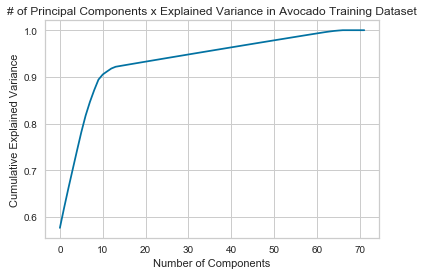

In [43]:
chooseNumComponents(avocado_X_train, "# of Principal Components x Explained Variance in Avocado Training Dataset")

In [45]:
pcaAvocadoTrain = PCA(n_components=11)
pcaAvocadoTrain.fit(avocado_X_train)
avocado_X_train_pca = pcaAvocadoTrain.transform(avocado_X_train)

It looks like we can still explain >90% of variance with 11 components. Copying our code from Assignment 1, we can use GridSearchCV to refit hyperparameters for our neural network and calculate validation and learning curves. 

In [46]:
# Calculate accuracy on training and validation set using range of parameter values
def calculateValidationCurve(estimator, X, Y, 
                             param_name, param_range,
                             title, xlabel, ylabel,
                             cv=5, scoring="accuracy",
                             lw=2, n_jobs=1):
    
    train_scores, validation_scores = validation_curve(estimator, 
                                                 X, 
                                                 Y, 
                                                 param_name, 
                                                 param_range,
                                                 cv=cv, 
                                                 scoring=scoring, 
                                                 n_jobs=n_jobs)
    
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    validation_mean = np.mean(validation_scores, axis=1)
    validation_std = np.std(validation_scores, axis=1)

    # Plot mean accuracy scores for training and validation sets
    plt.plot(param_range, train_mean, label="Training score", color="darkorange", lw=lw)
    plt.plot(param_range, validation_mean, label="Cross-validation score", color="navy", lw=lw)

    # Plot accurancy bands for training and validation sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange", lw=lw)
    plt.fill_between(param_range, validation_mean - validation_std, validation_mean + validation_std, alpha=0.2, color="navy", lw=lw)

    # Create plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.grid()
    plt.legend(loc="best")
    return plt
    
def plotLearningCurve(estimator, X, Y,
                      title, xlabel, ylabel,
                      ylim=None, cv=5, scoring="accuracy",
                      n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, 
        cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plot mean and standard deviation for training and cross-validation learning curves
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [50]:
parameters_multiple = {'solver': ['adam', 'lbfgs'], 'max_iter': [50,100,200], 'alpha' : 10.0 ** -np.arange(1, 7), 
                       'hidden_layer_sizes': [(5), (10), (15)], 'verbose':[3], 'random_state': [1]}
    
clf_grid_multi = GridSearchCV(MLPClassifier(), parameters_multiple, scoring = "accuracy", n_jobs=2)

clf_grid_multi.fit(avocado_X_train_pca, avocado_Y_train.values.ravel())

print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_multi.best_score_)
print("Using the following parameters:")
print(clf_grid_multi.best_params_)
print("------------------------------------------------------")

-----------------Original Features--------------------
Best score: 0.4794
Using the following parameters:
{'alpha': 0.001, 'hidden_layer_sizes': 15, 'max_iter': 200, 'random_state': 1, 'solver': 'lbfgs', 'verbose': 3}
------------------------------------------------------


GridSearchCV recommended alpha = 0.001, a hidden layer of 15 nodes, using solver 'lbfgs.' We calculate a validation curve using those hyperparameters:

<module 'matplotlib.pyplot' from '/Users/ericgu/Library/Python/3.6/lib/python/site-packages/matplotlib/pyplot.py'>

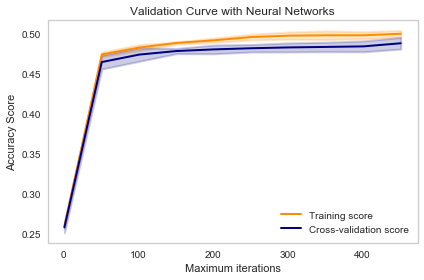

In [51]:
calculateValidationCurve(MLPClassifier(alpha=0.001, hidden_layer_sizes=(15), random_state=1, solver='lbfgs', verbose=False), 
                         avocado_X_train_pca, avocado_Y_train.values.ravel(),
                         "max_iter", range(1,500,50),
                         "Validation Curve with Neural Networks", "Maximum iterations", "Accuracy Score", 
                         scoring="accuracy", n_jobs=8)

It looks like we see diminishing returns after 50 or 100 max iterations—that is, the neural network's performance (using accuracy score because we have balanced classes) on cross-validation data does not benefit from additional upper-limit computation time. Going with 100 max iterations, let's see the learning curves for training and CV:

<module 'matplotlib.pyplot' from '/Users/ericgu/Library/Python/3.6/lib/python/site-packages/matplotlib/pyplot.py'>

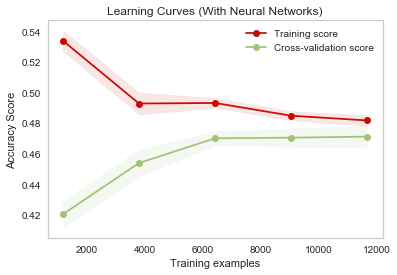

In [52]:
plotLearningCurve(MLPClassifier(alpha=0.001, hidden_layer_sizes=(15), random_state=1, solver='lbfgs', max_iter=100, verbose=False),
                  avocado_X_train_pca, avocado_Y_train.values.ravel(), 
                  "Learning Curves (With Neural Networks)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=8)

At this point, it's clear that this neural network does not perform as well as on the PCA-transformed dataset as one fit on all the original Avocado dataset features from Assignment 1, but the algorithm's accuracy score on 5-fold CV is an impressive improvement over its unsupervised clustering algorithm counterparts. The training and CV accuracy scores converge at around 48%, which means the neural network was predicting roughly half of the CV dataset's labels correctly. This is a significant improvement over the ARI of 0.150 for *K*-means and ARI of 0.013 for GMM on PCA-transformed data, which was little better than random assignment. 

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.298  0.132  0.282  0.113  0.175]
 [ 0.183  0.332  0.103  0.326  0.055]
 [ 0.233  0.024  0.388  0.028  0.327]
 [ 0.074  0.223  0.039  0.636  0.028]
 [ 0.098  0.004  0.29   0.004  0.604]]


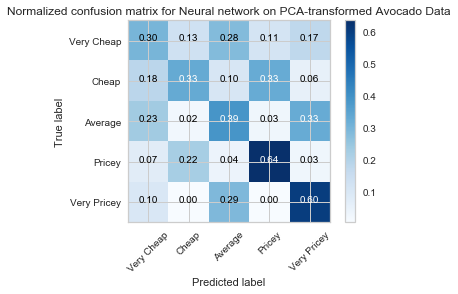

              precision    recall  f1-score   support

  Very Cheap       0.34      0.30      0.32       744
       Cheap       0.46      0.33      0.39       725
     Average       0.34      0.39      0.37       712
      Pricey       0.58      0.64      0.61       745
 Very Pricey       0.51      0.60      0.55       724

   micro avg       0.45      0.45      0.45      3650
   macro avg       0.45      0.45      0.45      3650
weighted avg       0.45      0.45      0.45      3650



In [65]:
# Applying same PCA as training set to test set
avocado_X_test_pca = pcaAvocadoTrain.transform(avocado_X_test)

# Training model on entire PCA training set
avocado_pca_neuralNet = MLPClassifier(alpha=0.001, hidden_layer_sizes=(15), random_state=1, solver='lbfgs', 
                                  max_iter=100, verbose=False).fit(avocado_X_train_pca, avocado_Y_train.values.ravel())

# Predicting on X_test
avocado_pca_neuralNet_Y_test_pred = avocado_pca_neuralNet.predict(avocado_X_test_pca)

cnf_matrix = confusion_matrix(avocado_Y_test.values.ravel(), avocado_pca_neuralNet_Y_test_pred)
np.set_printoptions(precision=3)

plt.figure()
avocado_price_range_labels = ["Very Cheap", "Cheap", "Average", "Pricey", "Very Pricey"]
plot_confusion_matrix(cnf_matrix, classes=avocado_price_range_labels, normalize=True,
                      title='Normalized confusion matrix for Neural network on PCA-transformed Avocado Data')

plt.show()

print(classification_report(avocado_Y_test, avocado_pca_neuralNet_Y_test_pred, target_names=avocado_price_range_labels))

Curiously, the neural network confusion matrix had a checkerboard-like appearance, where the algorithm opted to make label predictions either on the true price range or 1 removed from the true label's neighbors, but rarely on the true label's neighbors themselves. This may be because of the nature of the dataset, where true average prices of avocados were discretized into 5 classes (price ranges), which were sometimes very narrow price ranges because the dataset was skewed right. It may be that the neural network is more confident about categorizing avocados into more extreme or median labels, but is not as sure about the in-between labels. 

Overall, the performance on our PCA-transformed Avocado test dataset is 45% (both precision and recall), quite similar to the predicted performance based on cross-validation. It runs in <5 seconds, so given computational constraints, it seems preferable to reduce complex datasets using PCA before fitting a neural network rather than fitting on clustering algorithms. 

## Neural Networks, using Clustering Algorithms as Dimensionality Reduction

Finally, we can try substituting PCA with both of our clustering algorithms on the same Avocado problem, using the clustering algorithms' outputs as new features to input to the neural network instead of PCA's. We've already determined _k_ earlier and need to provide input features to the neural network that can suggest the correct number of possible output classes, so we will use the same number of clusters / components as classes. 

Our *K*-means will transform the raw input features for each data point into cluster-distance space as new features for input into the neural network, while the GMM will provide the posterior probability of belonging to each cluster. 

In [101]:
avocadoKMeans = KMeans(init='k-means++', n_clusters=5, n_init=50)

In [102]:
avocadoKMeansModel = avocadoKMeans.fit(avocado_X_train)
avocadoKMeans_clusterdist = avocadoKMeansModel.transform(avocado_X_train)

In [105]:
print(avocadoKMeans_clusterdist[:20])

[[  2.405  21.808   1.913   4.362  29.545]
 [  1.916  21.257   2.428   3.658  28.979]
 [  2.402  21.801   1.915   4.37   29.546]
 [  1.899  21.664   2.353   4.037  29.45 ]
 [  2.426  21.798   1.93    4.336  29.536]
 [  1.931  21.593   2.378   3.918  29.313]
 [  2.421  21.785   1.944   4.397  29.563]
 [  1.903  21.552   2.372   3.914  29.277]
 [  1.918  21.572   2.394   4.004  29.351]
 [  2.003  21.478   2.475   3.901  29.159]
 [  2.224  20.589   2.754   3.28   28.467]
 [  1.928  21.565   2.386   3.962  29.351]
 [  2.386  21.806   1.887   4.338  29.546]
 [  2.384  21.78    1.895   4.366  29.562]
 [  4.297  19.007   4.74    2.893  26.075]
 [  2.418  21.777   1.94    4.377  29.554]
 [  1.969  21.731   2.393   4.068  29.452]
 [  2.389  21.746   1.895   4.261  29.467]
 [  2.375  21.77    1.88    4.322  29.532]
 [  2.394  21.797   1.891   4.329  29.537]]


In [103]:
avocadoGMM = GaussianMixture(n_components=5, n_init=50, init_params="kmeans", covariance_type="full")

In [94]:
avocadoGMMModel = avocadoGMM.fit(avocado_X_train)
avocadoGMM_componentprob = avocadoGMMModel.predict_proba(avocado_X_train)

In [107]:
print(avocadoGMM_componentprob[:20])

[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]]


Cluster distance seems to be a straightforward transformation: how far away from each cluster center is a given data point? Though the clusters may be overlapping and have poor accuracy, the neural networks have access to the ground truth and might be able to map the clustering algorithms' outputs to the correct label. 

It seems that the GMM is very certain about the posterior probabilities of each component for the data it has already trained on—I suspect that this may translate to less nuanced information for the neural network to sift through. 

We'll go ahead and just use GridSearchCV to fit hyperparameters for the neural networks on the respective sets of input features. 

### *K*-means

In [112]:
parameters_multiple = {'solver': ['lbfgs'], 'max_iter': [50,100,200], 'alpha' : 10.0 ** -np.arange(1, 7), 
                       'hidden_layer_sizes': [(2), (5), (10), (15)], 'verbose':[3], 'random_state': [1]}

clf_grid_multi = GridSearchCV(MLPClassifier(), parameters_multiple, scoring = "accuracy", n_jobs=4)
clf_grid_multi.fit(avocadoKMeans_clusterdist, avocado_Y_train.values.ravel())

print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_multi.best_score_)
print("Using the following parameters:")
print(clf_grid_multi.best_params_)
print("------------------------------------------------------")

-----------------Original Features--------------------
Best score: 0.3924
Using the following parameters:
{'alpha': 0.001, 'hidden_layer_sizes': 15, 'max_iter': 200, 'random_state': 1, 'solver': 'lbfgs', 'verbose': 3}
------------------------------------------------------


<module 'matplotlib.pyplot' from '/Users/ericgu/Library/Python/3.6/lib/python/site-packages/matplotlib/pyplot.py'>

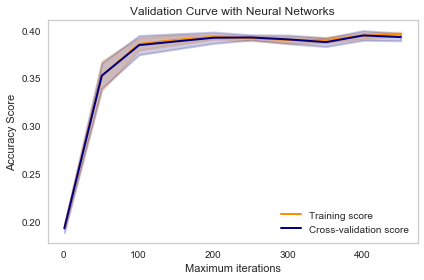

In [113]:
calculateValidationCurve(MLPClassifier(alpha=0.001, hidden_layer_sizes=(15), random_state=1, solver='lbfgs', verbose=False), 
                         avocadoKMeans_clusterdist, avocado_Y_train.values.ravel(),
                         "max_iter", range(1,500,50),
                         "Validation Curve with Neural Networks", "Maximum iterations", "Accuracy Score", 
                         scoring="accuracy", n_jobs=8)

<module 'matplotlib.pyplot' from '/Users/ericgu/Library/Python/3.6/lib/python/site-packages/matplotlib/pyplot.py'>

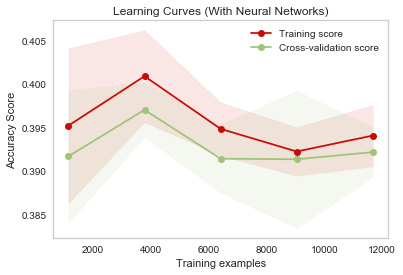

In [114]:
plotLearningCurve(MLPClassifier(alpha=0.001, hidden_layer_sizes=(15), random_state=1, solver='lbfgs', max_iter=400, verbose=False),
                  avocadoKMeans_clusterdist, avocado_Y_train.values.ravel(), 
                  "Learning Curves (With Neural Networks)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=8)

Using the exact same neural networks as in the past (ReLU activation, single layer 15 hidden nodes, 400 max iterations, 'lbfgs' solver), the cross-validation accuracy hovers at around 39%. 

Normalized confusion matrix
[[ 0.     0.     0.543  0.     0.457]
 [ 0.     0.004  0.255  0.008  0.732]
 [ 0.     0.     0.728  0.     0.272]
 [ 0.     0.008  0.136  0.004  0.852]
 [ 0.     0.     0.923  0.     0.077]]


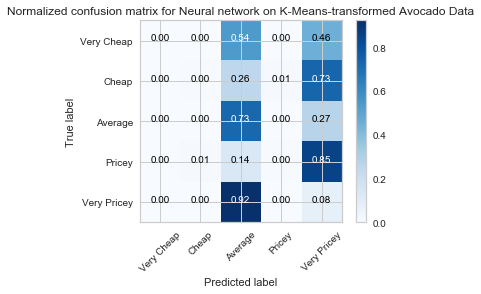

              precision    recall  f1-score   support

  Very Cheap       0.00      0.00      0.00       744
       Cheap       0.33      0.00      0.01       725
     Average       0.28      0.73      0.40       712
      Pricey       0.33      0.00      0.01       745
 Very Pricey       0.03      0.08      0.05       724

   micro avg       0.16      0.16      0.16      3650
   macro avg       0.19      0.16      0.09      3650
weighted avg       0.19      0.16      0.09      3650



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
# Dimensionality reduction of X_test using K-means
avocadoKMeansModel_test = avocadoKMeans.fit(avocado_X_test)
avocadoKMeans_clusterdist_test = avocadoKMeansModel_test.transform(avocado_X_test)

# Training model on entire PCA training set
avocadoKMeans_neuralNet = MLPClassifier(alpha=0.001, hidden_layer_sizes=(15), random_state=1, solver='lbfgs', 
                                  max_iter=400, verbose=False).fit(avocadoKMeans_clusterdist, avocado_Y_train.values.ravel())

# Predicting on X_test
avocadoKMeans_neuralNet_Y_test_pred = avocadoKMeans_neuralNet.predict(avocadoKMeans_clusterdist_test)

cnf_matrix = confusion_matrix(avocado_Y_test.values.ravel(), avocadoKMeans_neuralNet_Y_test_pred)
np.set_printoptions(precision=3)

plt.figure()
avocado_price_range_labels = ["Very Cheap", "Cheap", "Average", "Pricey", "Very Pricey"]
plot_confusion_matrix(cnf_matrix, classes=avocado_price_range_labels, normalize=True,
                      title='Normalized confusion matrix for Neural network on K-Means-transformed Avocado Data')

plt.show()

print(classification_report(avocado_Y_test, avocadoKMeans_neuralNet_Y_test_pred, target_names=avocado_price_range_labels))

The results are extremely bad. The neural network essentially predicts only one of two labels: 'Average' or 'Very Pricey.' This makes sense seeing as how much difficulty both clustering algorithms had in sussing out the different labels—any given point was similar in distance to the centers of several of the clusters because of how much the clusters overlapped. The overall accuracy is <20%, meaning the classifier performed worse than guessing. 

### GMMs

In [122]:
parameters_multiple = {'solver': ['lbfgs'], 'max_iter': [50,100,200], 'alpha' : 10.0 ** -np.arange(1, 7), 
                       'hidden_layer_sizes': [(2), (5), (10), (15)], 'verbose':[3], 'random_state': [1]}

clf_grid_multi = GridSearchCV(MLPClassifier(), parameters_multiple, scoring = "accuracy", n_jobs=4)
clf_grid_multi.fit(avocadoGMM_componentprob, avocado_Y_train.values.ravel())

print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_multi.best_score_)
print("Using the following parameters:")
print(clf_grid_multi.best_params_)
print("------------------------------------------------------")

-----------------Original Features--------------------
Best score: 0.2623
Using the following parameters:
{'alpha': 0.01, 'hidden_layer_sizes': 10, 'max_iter': 50, 'random_state': 1, 'solver': 'lbfgs', 'verbose': 3}
------------------------------------------------------


<module 'matplotlib.pyplot' from '/Users/ericgu/Library/Python/3.6/lib/python/site-packages/matplotlib/pyplot.py'>

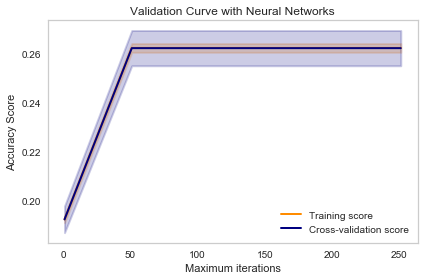

In [123]:
calculateValidationCurve(MLPClassifier(alpha=0.01, hidden_layer_sizes=(10), random_state=1, solver='lbfgs', verbose=False), 
                         avocadoGMM_componentprob, avocado_Y_train.values.ravel(),
                         "max_iter", range(1,300,50),
                         "Validation Curve with Neural Networks", "Maximum iterations", "Accuracy Score", 
                         scoring="accuracy", n_jobs=8)

<module 'matplotlib.pyplot' from '/Users/ericgu/Library/Python/3.6/lib/python/site-packages/matplotlib/pyplot.py'>

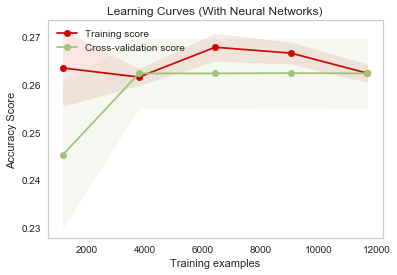

In [124]:
plotLearningCurve(MLPClassifier(alpha=0.01, hidden_layer_sizes=(10), random_state=1, solver='lbfgs', max_iter=50, verbose=False),
                  avocadoGMM_componentprob, avocado_Y_train.values.ravel(), 
                  "Learning Curves (With Neural Networks)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=8)

Normalized confusion matrix
[[ 0.001  0.     0.382  0.617  0.   ]
 [ 0.019  0.     0.299  0.681  0.   ]
 [ 0.004  0.     0.338  0.657  0.   ]
 [ 0.021  0.     0.401  0.577  0.   ]
 [ 0.     0.     0.305  0.695  0.   ]]


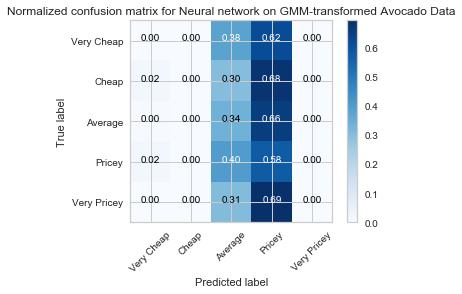

              precision    recall  f1-score   support

  Very Cheap       0.03      0.00      0.00       744
       Cheap       0.00      0.00      0.00       725
     Average       0.19      0.34      0.24       712
      Pricey       0.18      0.58      0.28       745
 Very Pricey       0.00      0.00      0.00       724

   micro avg       0.18      0.18      0.18      3650
   macro avg       0.08      0.18      0.10      3650
weighted avg       0.08      0.18      0.10      3650



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [133]:
# Dimensionality reduction of X_test using GMM
avocadoGMMModel_test = avocadoGMM.fit(avocado_X_test)
avocadoGMM_componentprob_test = avocadoGMMModel_test.predict_proba(avocado_X_test)

# Training model on entire PCA training set
avocadoGMM_neuralNet = MLPClassifier(alpha=0.01, hidden_layer_sizes=(10), random_state=1, solver='lbfgs', 
                                  max_iter=50, verbose=False).fit(avocadoGMM_componentprob, avocado_Y_train.values.ravel())

# Predicting on X_test
avocadoGMM_neuralNet_Y_test_pred = avocadoGMM_neuralNet.predict(avocadoGMM_componentprob_test)

cnf_matrix = confusion_matrix(avocado_Y_test.values.ravel(), avocadoGMM_neuralNet_Y_test_pred)
np.set_printoptions(precision=3)

plt.figure()
avocado_price_range_labels = ["Very Cheap", "Cheap", "Average", "Pricey", "Very Pricey"]
plot_confusion_matrix(cnf_matrix, classes=avocado_price_range_labels, normalize=True,
                      title='Normalized confusion matrix for Neural network on GMM-transformed Avocado Data')

plt.show()

print(classification_report(avocado_Y_test, avocadoGMM_neuralNet_Y_test_pred, target_names=avocado_price_range_labels))

Unfortunately, much of the lackluster performance in the clustering algorithms carried over to the neural network. Similar to the neural network fed from a *K*-means transformed dataset, the one built on GMM classified nearly everything in one of two classes: either 'Average' or 'Pricey.' The accuracy is <20%, worse than guessing. 